*Copyright (c) Cornac Authors. All rights reserved.*

*Licensed under the Apache 2.0 License.*

#Visual Bayesian Personalizer Ranking (VBPR) with Text Data

<br><br>
In this tutorial, we will employ a recommendation algorithm, designed to leverage item images, to work with item text content.
The model of interest here is [VBPR](https://arxiv.org/abs/1510.01784) that makes use of visual features extracted from item images using pre-trained CNN deep networks.

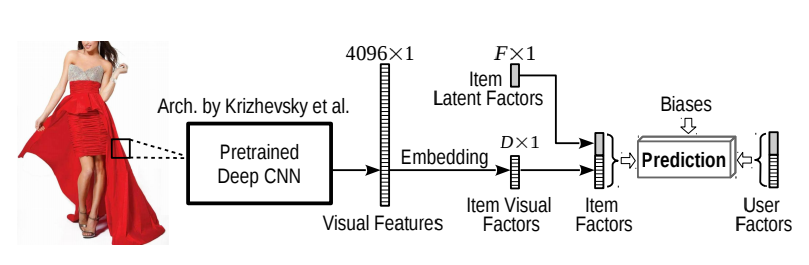

<br>
However, what if our data doesn't come with item images but text, for example, we are working with [MovieLens dataset](https://grouplens.org/datasets/movielens/) that contains text plot of the movies. At the same time, we also want to work with VBPR model which is not originally designed to work with text data. Thus, Cornac provides simple mechanisms to cross between modalities, in which here we focus on crossing from text to image to utilize image models for text-available datasets.

To quickly give an overview of the process, we are going to go through following steps:
1. Use `TextModality` to build representations (e.g., bag-of-words, tf-idf) from raw text data.
2. Construct `ImageModality`, which will be used by `VBPR` model, from textual representations.
3. Split data using provided `RatioSplit` evaluation method.
4. Define models and metrics used to evaluate models' performance.
5. Test the models by running an experiment

In [ ]:
import cornac
from cornac.data import Reader
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality, ImageModality
from cornac.data.text import BaseTokenizer

Here we use MovieLens 100K dataset as already provided inside Cornac library. We load movie plots with their corresponding ids, then load the rating data filtered the movies that don't come with plots.

In [2]:
# load movie plots from built-in movielens datasets
plots, movie_ids = movielens.load_plot()

# load rating data of MovieLens 100K
# movies without plot are filtered out using `cornac.data.Reader`
ml_100k = movielens.load_100k(reader=Reader(item_set=movie_ids))

To get representations from text data, we build a `TextModality` using text corpus with coressponding ids as the input. We also need to supply a `Tokenizer` for text splitting, in this case the tokens in text plots are seperated by `\tab` character. We limit the maximum size of vocabulary to 5000, which also means the size of representations (e.g., bag-of-words vectors) can not go beyond that limit.

In [18]:
# we need a tokenizer to split text into tokens using \tab character as text seperator
# we also tell the tokenizer to ignore English stopwords
tokenizer = BaseTokenizer(sep='\t', stop_words='english')

# now we can build a TextModality given movie plots and their corresponding ids
item_text_modality = TextModality(corpus=plots, ids=movie_ids, 
                                  tokenizer=tokenizer,
                                  max_vocab=5000, max_doc_freq=0.5).build()

After building the `TextModality`, we can access text representations through provided APIs and attributes of the object. In this case, we take the word-count matrix as item representations then use it as input to construct an `ImageModality`. In other words, item visual representations will be substituted by bag-of-words representations which are used by `VBPR` model. 

In [5]:
# word-count matrix from TextModality will be used as input features to construct an ImageModality
# the `count_matrix` is originally stored in sparse format, we need to turn it into dense format
features = item_text_modality.count_matrix.A

# construct an ImageModality given features and movie ids as the input
item_image_modality = ImageModality(features=features, ids=movie_ids)

In Cornac, image recommendation models always work with `ImageModality`, similarly for other modalities. That design makes it easier to integrate models into the library without confusion of data input, as well as makes it consistent with models' original assumptions.

We employ `RatioSplit` evaluation method to split the rating data. The `item_image_modality` is also supplied here for later usage of model training.

In [6]:
ratio_split = RatioSplit(data=ml_100k, test_size=0.2,
                         item_image=item_image_modality,
                         exclude_unknowns=True, 
                         verbose=True, seed=123)

rating_threshold = 1.0
exclude_unknowns = True
Splitting the data
Building training set
Number of training users = 943
Number of training items = 1518
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
Building test set
Number of tested users = 941
Number of unknown users = 0
Number of unknown items = 28
Total users = 943
Total items = 1546


VBPR model is supported inside Cornac. Note that the VBPR implementation uses [PyTorch](https://pytorch.org/), thus we need to install that dependency in order to run the model. List of implemented models with their additional dependencies is carefully documented [here](https://github.com/PreferredAI/cornac#models).

In [14]:
# instantiate VBPR model with the model hyper-parameters
vbpr = cornac.models.VBPR(k=10, k2=20, n_epochs=30, batch_size=100, learning_rate=0.005,
                          lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, seed=123)

# BPR is used as a baseline
bpr = cornac.models.BPR(k=30, max_iter=30, learning_rate=0.01, lambda_reg=0.001, seed=123)

In [16]:
# we use `AUC` and `Recall@50` to measure models' performance
auc = cornac.metrics.AUC()
rec_50 = cornac.metrics.Recall(k=50)

In [17]:
# run an experiment to test the models
cornac.Experiment(eval_method=ratio_split,
                  models=[bpr, vbpr],
                  metrics=[auc, rec_50]).run()


[BPR] Training started!


 32%|███▏      | 301/941 [00:00<00:00, 1499.79it/s]


[BPR] Evaluation started!


Epoch 1/30:   2%|▏         | 13/759 [00:00<00:05, 125.95it/s, loss=66.8]


[VBPR] Training started!


 27%|██▋       | 256/941 [00:00<00:00, 1278.20it/s]

Optimization finished!

[VBPR] Evaluation started!


100%|██████████| 941/941 [00:00<00:00, 1161.25it/s]


     |    AUC | Recall@50 | Train (s) | Test (s)
---- + ------ + --------- + --------- + --------
BPR  | 0.8204 |    0.2236 |    0.2269 |   0.5853
VBPR | 0.8587 |    0.3012 |  199.3364 |   0.8134

